In [10]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
from scipy.stats import norm
from scipy.optimize import brentq
import plotly.express as px
import plotly.graph_objects as go
from scipy.interpolate import griddata
import matplotlib.dates as mdates

In [11]:
def get_df(day):
    file_name = f"prices_round_3_day_{day}.csv"
    df = pd.read_csv(file_name, sep = ';')
    df['timestamp'] = df['timestamp'] + 1_000_000 * day
    return df

def get_product(df, product):
    return df[df['product'] == product].copy()

def black_scholes_price_call(S, K, T, sigma):
    d1 = (np.log(S/K) + 0.5*sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*norm.cdf(d2)

def implied_volatility(call_price, S, K, T, tol=1e-6):
    """Bisection between [1e-3,3.0]"""
    f = lambda sigma: black_scholes_price_call(S, K, T, sigma) - call_price
    try:
        return brentq(f, 1e-3, 3.0, xtol=tol)
    except ValueError:
        return np.nan

In [12]:
DAYS = range(5)
VOUCHER_STRIKES = [9500, 9750, 10000, 10250, 10500]
UNDERLYING = "VOLCANIC_ROCK"
V_PREFIX = "VOLCANIC_ROCK_VOUCHER_"

rows = []

for day in DAYS:
    df = get_df(day)

    u = get_product(df, UNDERLYING)[['timestamp', 'mid_price']].rename(columns={'mid_price': 'spot_price'})

    T = ( (7 - day) /247 )

    for K in VOUCHER_STRIKES:

        prod = f"{V_PREFIX}{K}"
        v = get_product(df, prod)[['timestamp', 'mid_price']].rename(columns={'mid_price': 'call_price'})

        m = pd.merge(v, u, on='timestamp', how='inner')
        m['strike']= K
        m['day'] = day
        m['TTM'] = T

        m['IV'] = np.vectorize(implied_volatility)(
            m['call_price'].to_numpy(),
            m['spot_price'].to_numpy(),
            m['strike'].to_numpy(),
            m['TTM'].to_numpy()
        )

        rows.append(m)

iv_df = pd.concat(rows, ignore_index = True)

In [13]:
T0_days = 7.0
ticks_per_day = 1_000_000.0
trading_days = 247.0

iv_df['day_fraction'] = (
    iv_df['day']
    + (iv_df['timestamp'] % ticks_per_day) / ticks_per_day
)

iv_df['TTM_dynamic'] = (T0_days - iv_df['day_fraction']) / trading_days

iv_df = iv_df.drop(columns='TTM').rename(columns={'TTM_dynamic': 'TTM'})
print(iv_df.dropna())

        timestamp  call_price  spot_price  strike  day        IV  \
0               0      1003.5     10503.0    9500    0  0.226366   
1             100      1010.5     10510.0    9500    0  0.227702   
2             200      1013.5     10513.0    9500    0  0.228273   
3             300      1018.0     10517.5    9500    0  0.229130   
4             400      1010.0     10509.5    9500    0  0.227606   
...           ...         ...         ...     ...  ...       ...   
249995    4999500         1.0     10105.0   10500    4  0.161065   
249996    4999600         1.0     10106.0   10500    4  0.160707   
249997    4999700         1.0     10106.5   10500    4  0.160528   
249998    4999800         1.0     10105.0   10500    4  0.161065   
249999    4999900         1.0     10105.0   10500    4  0.161065   

        day_fraction       TTM  
0             0.0000  0.028340  
1             0.0001  0.028340  
2             0.0002  0.028339  
3             0.0003  0.028339  
4             0.00

In [14]:
df = iv_df[
    (iv_df['spot_price'] > 0) &
    (iv_df['call_price'] > 0) &
    (iv_df['IV'] > 0.002)
    ].copy()

x = df['strike'].values
y = df['TTM'].values
z = df['IV'].values

num_pts = 60
xi = np.linspace(x.min(), x.max(), num_pts)
yi = np.linspace(y.min(), y.max(), num_pts)
X, Y = np.meshgrid(xi, yi)

Z = griddata((x, y), z, (X, Y), method='cubic')

# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(
#     X, Y, Z,
#     cmap='viridis',
#     edgecolor='none',
#     alpha=0.8
# )
sample = df.sample(frac=0.1, random_state=1)

# ax.scatter(x, y, z, c="red", s=8, alpha=1,marker="o", depthshade=True)
# ax.set_xlabel("Strike")
# ax.set_ylabel("TTM (years)")
# ax.set_zlabel("Implied Vol (%)")
# ax.set_title("Implied Vol Surface — Matplotlib")
# plt.show()

surf = go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', showscale=True)
pts  = go.Scatter3d(
    x=sample['strike'], y=sample['TTM'], z=sample['IV'],
    mode='markers',
    marker=dict(size=3, color='red', opacity=1),
    name='Samples'
)
fig2 = go.Figure([surf, pts])
fig2.update_layout(
    title='Cleaned Implied Vol Surface — Plotly',
    scene=dict(
        xaxis_title='Strike',
        yaxis_title='TTM (years)',
        zaxis_title='IV %'
    ),
    width=800, height=700
)
fig2.show(renderer='browser')
fig2.show()

## I saw many teams working with this 3d vol surface, why is this redundant?

> - The maturity is constant throughout all the options, so the TTM is simply just a timeseries of the IV over different days, and does not add much information for us
> - The following 3d col smile is simply IV-evolution surface where:
>    - X = Strike
>    - Y = Clock-time
>    - Z = IV

In [15]:
iv_df['moneyness'] = np.log(iv_df['strike'] / iv_df['spot_price']) / iv_df['TTM']
iv_df = iv_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['moneyness', 'IV'])

In [16]:
def fit_quadratic(group):
    m = group['moneyness'].values
    v = group['IV'].values
    if len(m) < 3:
        return pd.Series({'a':np.nan, 'b':np.nan, 'c':np.nan})
    a,b,c = np.polyfit(m, v, 2)
    return pd.Series({'a':a, 'b':b, 'c':c})
bad_ts = (
    iv_df.loc[iv_df.IV < 0.002, 'timestamp'].unique()
)

df_clean = iv_df[~iv_df.timestamp.isin(bad_ts)].copy()
coeffs = df_clean.groupby('timestamp').apply(fit_quadratic)

/var/folders/0l/fp7l7x9n61x0hm8_y02kj7nw0000gn/T/ipykernel_9224/4053985669.py:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



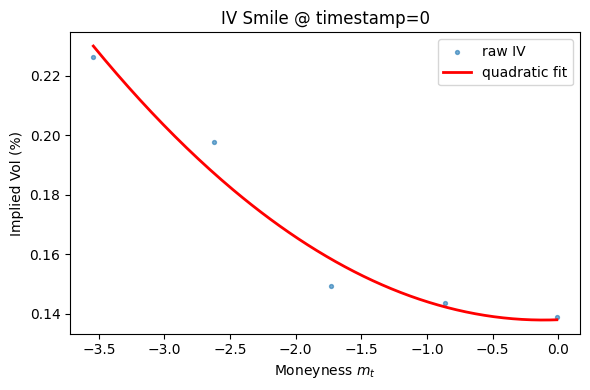

In [21]:
## WORKING ON IMC HINT

ts0 = coeffs.index[0]
slice0 = iv_df[iv_df['timestamp']==ts0]
a,b,c = coeffs.loc[ts0, ['a','b','c']]

mg = np.linspace(slice0.moneyness.min(), slice0.moneyness.max(), 200)
vg = a*mg**2 + b*mg + c

plt.figure(figsize=(6,4))
plt.scatter(slice0.moneyness, slice0.IV, s=8, alpha=0.6, label='raw IV')
plt.plot(mg, vg, 'r-', lw=2, label='quadratic fit')
plt.xlabel('Moneyness $m_t$')
plt.ylabel('Implied Vol (%)')
plt.title(f'IV Smile @ timestamp={ts0}')
plt.legend()
plt.tight_layout()
plt.show()

## Implementing the Hint given my IMC

* I expect everyone reading this to be familiar with the Black-Scholes Greeks, and how volatility affects option prices.

#### Hint

* Estimate implied volatility (v_t) at each timestamp using Black-Scholes, plot it against moneyness:

$$
  m_t = \frac{\ln\!\bigl(K / S_t\bigr)}{\sqrt{\text{TTE}}}
$$
* Then, fit a parabola to filter noise, and watch the time-series of the fitted at-the-money IV for trading signals across strikes.
* Most team spent a lot of time modeling the "Vol Smile", but failed to understand how you can use it.
* There were enough writeups from previous years that discussed Implied Vol mean reversion, We will not discuss that in our write up as most teams were able to understand and implement it.

### Key Mistake

* The Vol-Smile evolves as the underlying price (Volcanic Rock) changes, So does the VEGA!!
* It is not profitable to bet on 'Implied Vol Mean Reversion' if the VEGA is a small number!!
* Example:
> - When the spot price is 9,000 and TTE is 3 days, we can imagine the Call 15,000 to be:
>    - 1) Cheap
>    - 2) Have a small Vega
>    - 3) Illiquid
> - How does that affect us trading on Implied Vol Mean Reversion? (We discuss this below, but think about this)

* For now we have randomly selected 20 samples across 4 days to show how the Vol Smile is not constant through out the day.
* Below you will also find a little animation created by yours truly to showcase how the Vol Smile evolved everyday as a function of the Spot Price (Volcanic Rock).
* Make sure to turn the animations off using the next kernal so that you can plot the remaing graphs in the notebook.

/var/folders/0l/fp7l7x9n61x0hm8_y02kj7nw0000gn/T/ipykernel_9224/3683054293.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



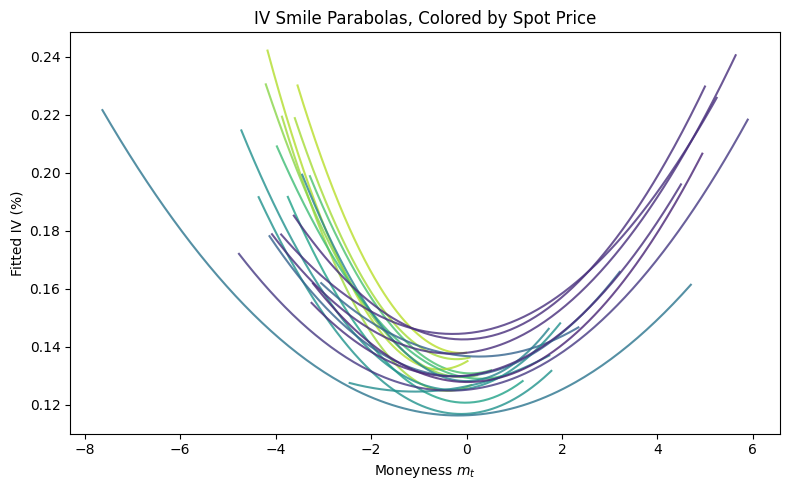

In [22]:
all_ts = sorted(coeffs.dropna().index)
n_samples = 20
step = max(1, len(all_ts)//n_samples)
sample_ts = all_ts[::step]

spot_by_ts = iv_df.groupby('timestamp').spot_price.first()
norm_color = Normalize(vmin=spot_by_ts.min(), vmax=spot_by_ts.max())
cmap = cm.get_cmap('viridis')

plt.figure(figsize=(8,5))
for t in sample_ts:
    S = spot_by_ts.loc[t]
    a,b,c = coeffs.loc[t, ['a', 'b', 'c']]
    df_t = iv_df[iv_df.timestamp==t]
    mg = np.linspace(df_t.moneyness.min(), df_t.moneyness.max(), 200)
    vg = a*mg**2 + b*mg + c
    color = cmap(norm_color(S))
    plt.plot(mg, vg, color=color, alpha=0.8)

sm = cm.ScalarMappable(norm = norm_color, cmap = cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Spot Price $S_t$')

plt.xlabel('Moneyness $m_t$')
plt.ylabel('Fitted IV (%)')
plt.title('IV Smile Parabolas, Colored by Spot Price')
plt.tight_layout()
plt.show()

/var/folders/0l/fp7l7x9n61x0hm8_y02kj7nw0000gn/T/ipykernel_9224/2306890013.py:13: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



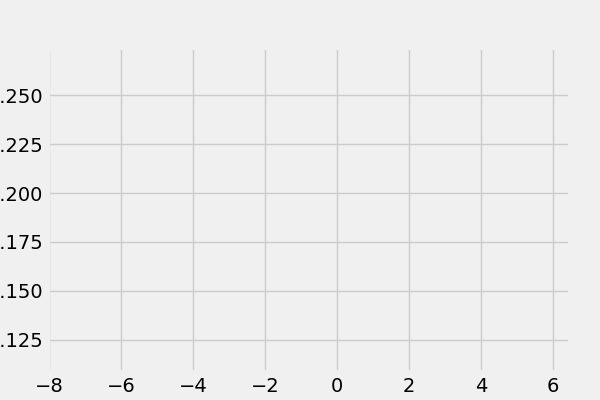

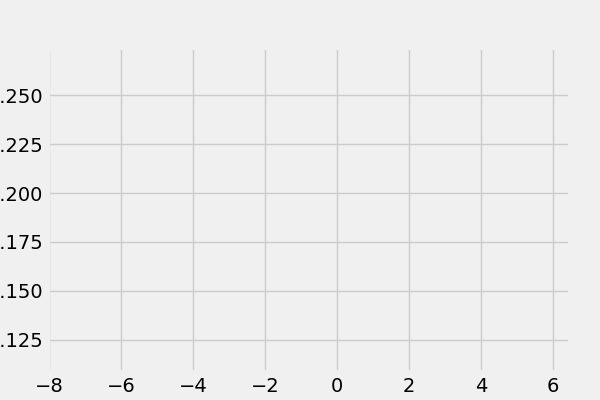

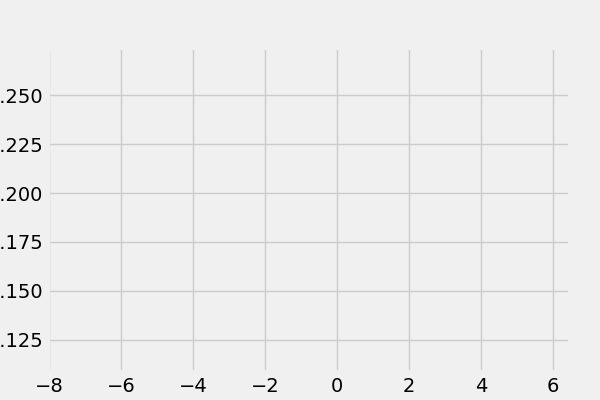

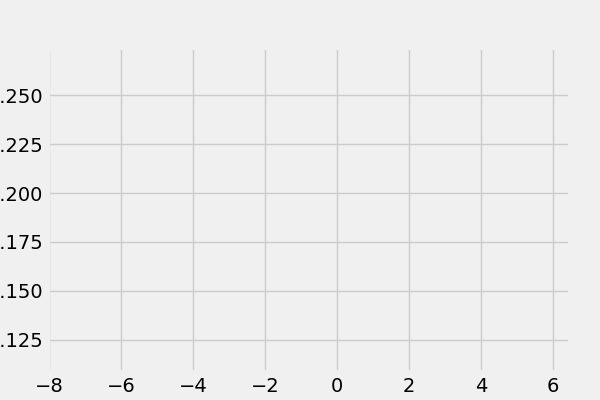

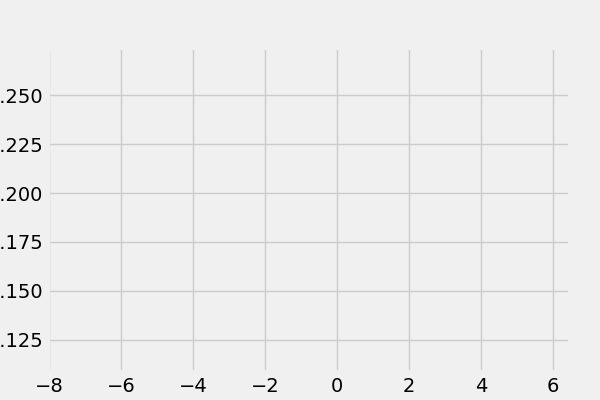

In [30]:
%matplotlib widget

df_filt = iv_df[iv_df.IV >= 0.02].copy()

def make_anim_for_day(day, n_frames=200, interval=300):
    df_day = df_filt[df_filt.day == day]
    spot_by_ts = df_day.groupby('timestamp').spot_price.first()
    all_ts = sorted(df_day.timestamp.unique())

    step = max(1, len(all_ts) // n_frames)
    timestamps = all_ts[::step][:n_frames]

    fig, ax = plt.subplots(figsize=(6,4))
    scat = ax.scatter([], [], s=8, alpha=0.6)
    line = ax.plot([], [], 'r-', lw=2)[0]
    ax.set_xlim(df_filt.moneyness.min(), df_filt.moneyness.max())
    ax.set_ylim(df_filt.IV.min(), df_filt.IV.max())
    ax.set_xlabel('Moneyness')
    ax.set_ylabel('Implied Vol (%)')

    def init():
        scat.set_offsets(np.empty((0,2)))
        line.set_data([], [])
        return scat, line

    def animate(i):
        t = timestamps[i]
        slice0 = iv_df[iv_df.timestamp == t]
        a,b,c = coeffs.loc[t, ['a', 'b', 'c']]
        mg = np.linspace(slice0.moneyness.min(), slice0.moneyness.max(), 200)
        vg = a*mg**2 + b*mg + c
        scat.set_offsets(np.column_stack([slice0.moneyness, slice0.IV]))
        line.set_data(mg, vg)
        ax.set_title(f"Day {day} | t={t} | Volcanic Rock Price={spot_by_ts.loc[t]:.2f}")
        return scat, line

    ani = FuncAnimation(
    fig, animate, init_func = init,
    frames = len(timestamps),
    interval=interval,
    blit = False
    )
    return ani

anims = []
for day in range(5):
    anim = make_anim_for_day(day, n_frames=200, interval=100)
    display(anim)
    anims.append(anim)

In [24]:
def stop_and_close(animations):

    for ani in animations:
        try:
            ani.event_source.stop()      # stop the timer
        except Exception:
            pass
        try:
            plt.close(ani._fig)         # close the figure
        except Exception:
            pass

stop_and_close(anims)
anims.clear()


## Timeseries Plot

* I think another mistake teams did was not plotting the Implied Vol against both the Call options and Spot Price, Doing this would have helped generate intuition for what we tried to discuss earlier.



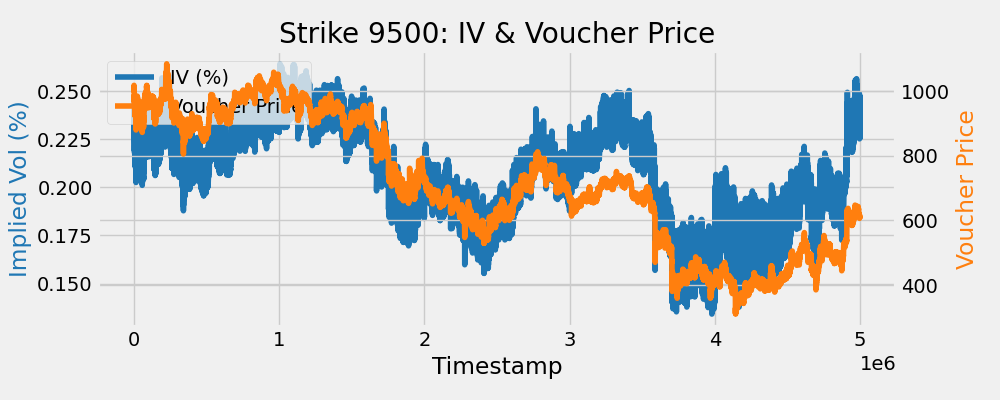

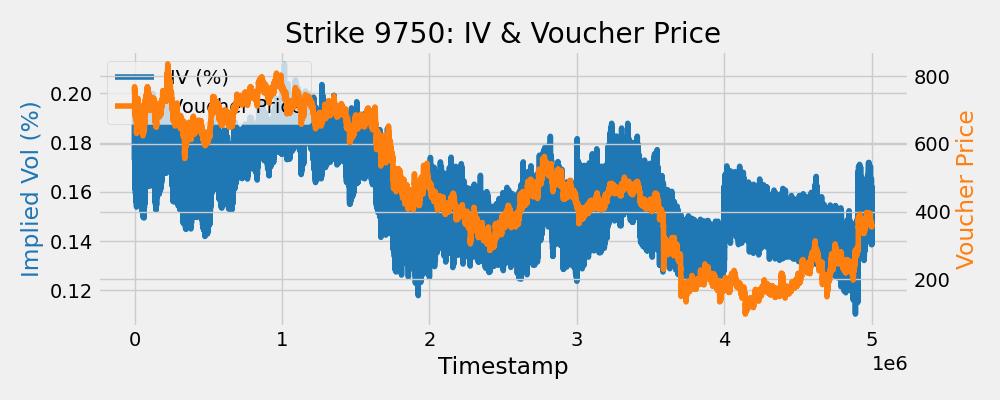

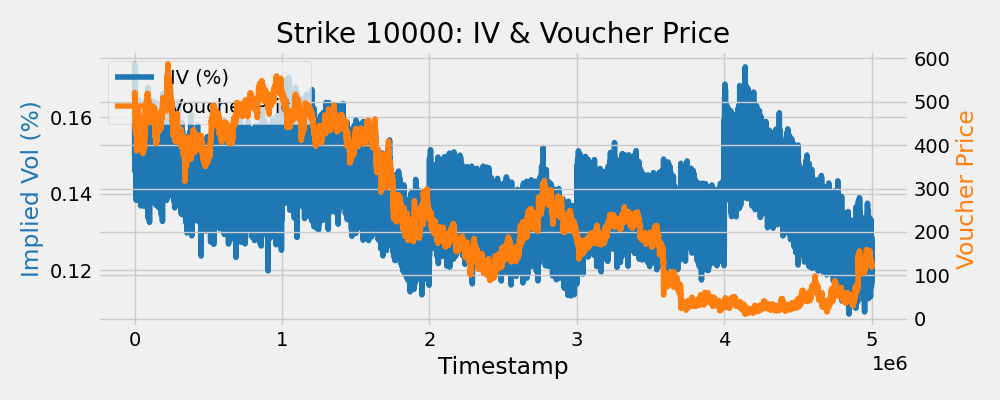

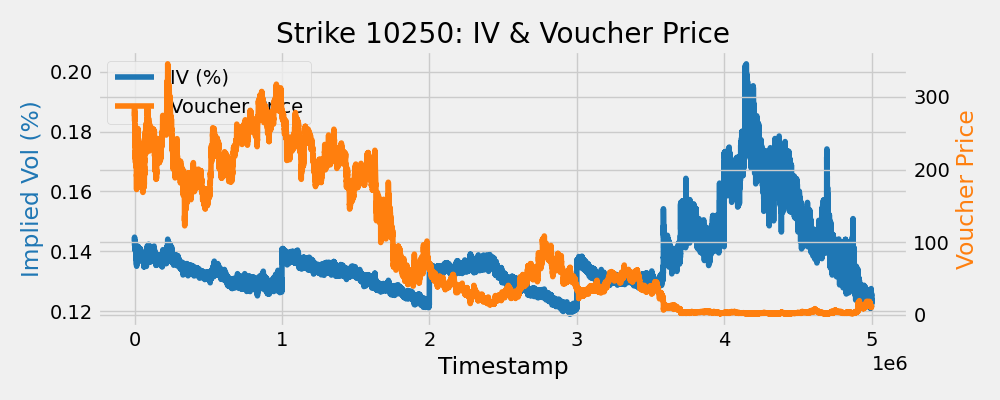

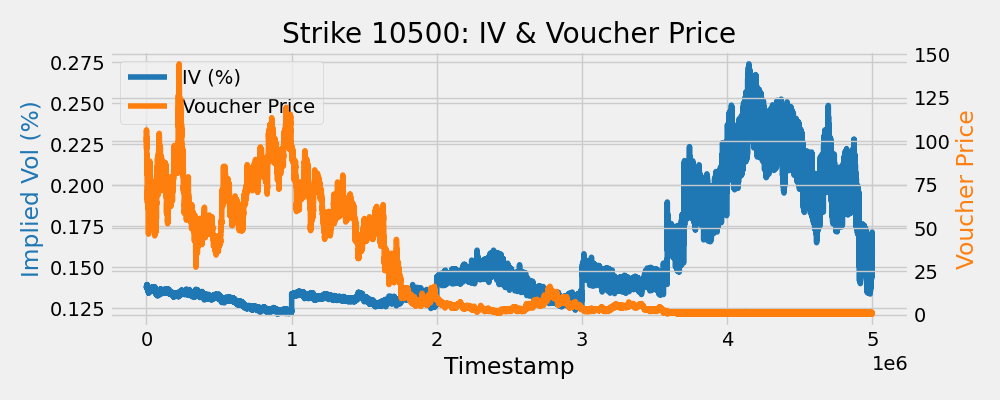

In [25]:
plt.style.use("fivethirtyeight")

for K in sorted(df_filt['strike'].unique()):
    dfk = df_filt[df_filt['strike'] == K].sort_values('timestamp')
    x = dfk['timestamp']

    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax2 = ax1.twinx()

    l1, = ax1.plot(x, dfk['IV'], color='tab:blue', label='IV (%)')
    l2, = ax2.plot(x, dfk['call_price'], color='tab:orange', label='Voucher Price')

    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Implied Vol (%)', color='tab:blue')
    ax2.set_ylabel('Voucher Price', color='tab:orange')
    ax1.set_title(f"Strike {K}: IV & Voucher Price")

    lines = [l1, l2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    plt.tight_layout()
    plt.show()

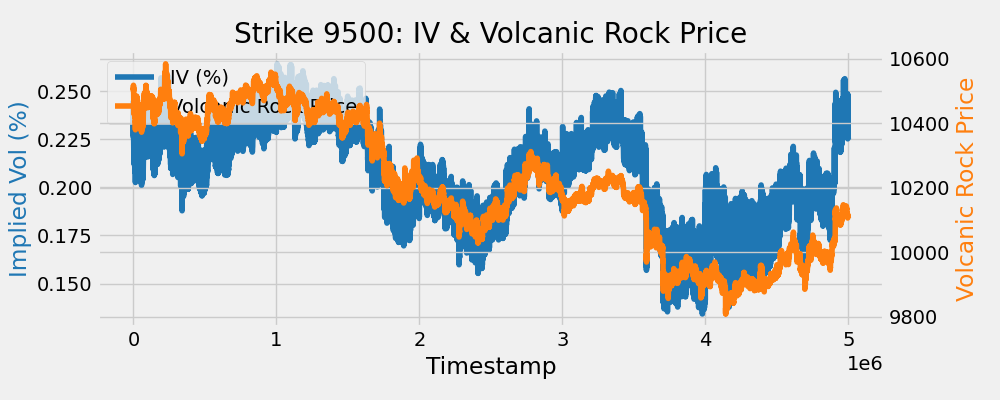

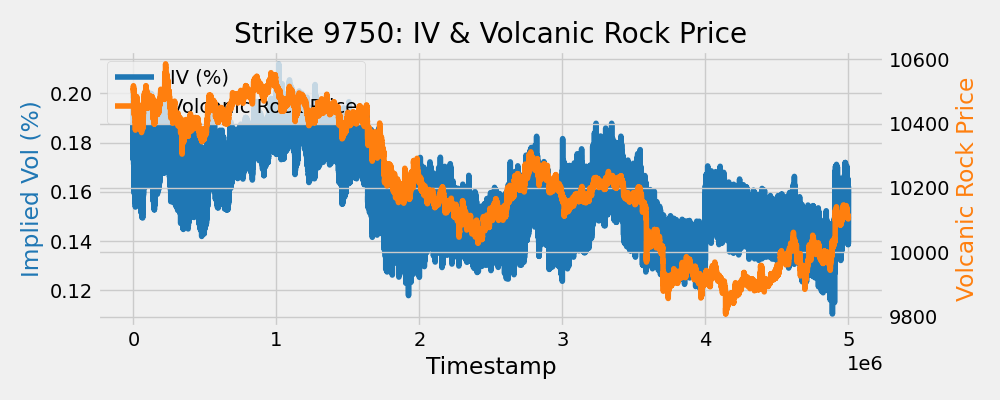

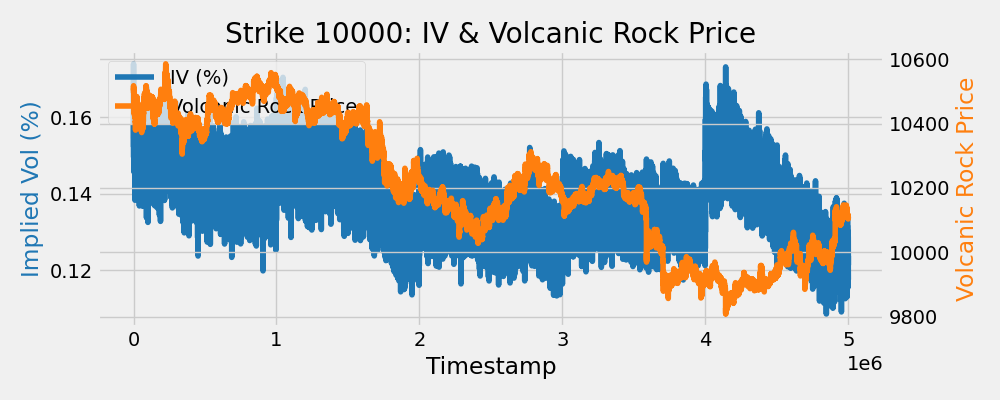

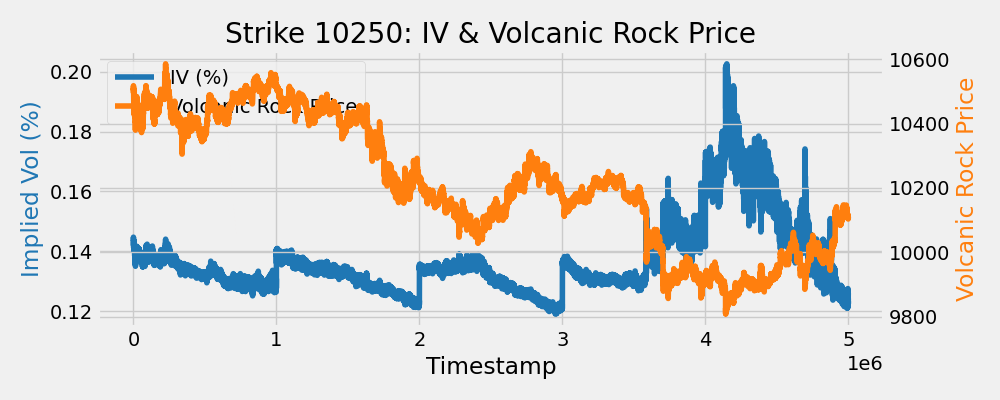

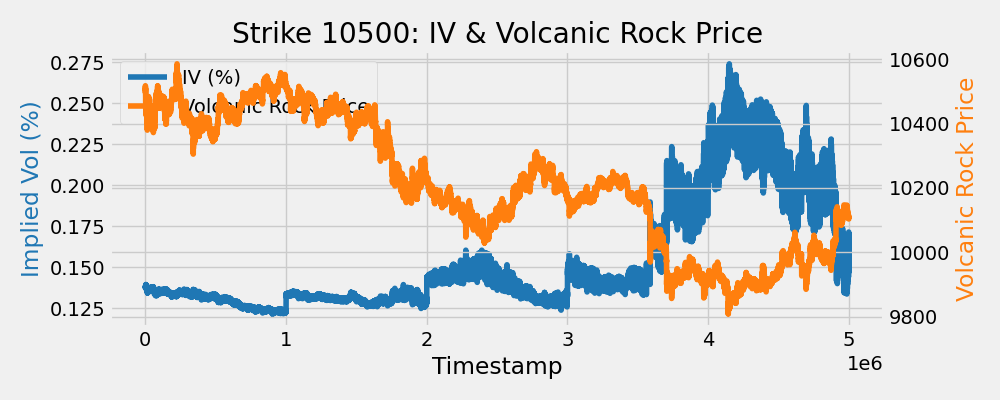

In [26]:
plt.style.use("fivethirtyeight")

for K in sorted(df_filt['strike'].unique()):
    dfk = df_filt[df_filt['strike'] == K].sort_values('timestamp')
    x = dfk['timestamp']

    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax2 = ax1.twinx()

    l1, = ax1.plot(x, dfk['IV'], color='tab:blue', label='IV (%)')
    l2, = ax2.plot(x, dfk['spot_price'], color='tab:orange', label='Volcanic Rock Price')

    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Implied Vol (%)', color='tab:blue')
    ax2.set_ylabel('Volcanic Rock Price', color='tab:orange')
    ax1.set_title(f"Strike {K}: IV & Volcanic Rock Price")

    lines = [l1, l2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    plt.tight_layout()
    plt.show()


## Using `plot_smile_at_price_day` and `plot_smile_and_prices` to Decode IV Dynamics

Below are two building-block functions.  Even if you never call them directly in production, they illustrate exactly **how** to explore:

1. **The instantaneous smile** at any spot level.
2. **Price vs. vol dynamics** around that moment, per strike.

---

### 1. `plot_smile_at_price_day`

```python
plot_smile_at_price_day(
    target_price: float,
    target_day:    int,
    df_iv:         pd.DataFrame,
    coeffs:        pd.DataFrame,
    day_window:    int = 1
)
```

| Argument       | What it does                                                             |
| -------------- | ------------------------------------------------------------------------ |
| `target_price` | Spot level you care about (e.g. 10 300)                                  |
| `target_day`   | Which day index (0…4) to search near                                     |
| `df_iv`        | Dataframe of $`timestamp`, `day`, `spot_price`,<br>`moneyness`, `IV`, …$ |
| `coeffs`       | Fit results: one row per `timestamp`, columns `[a,b,c]`                  |
| `day_window`   | How many days on either side of `target_day` to include                  |

**What it does under the hood**:

1. Restricts to days $day–window … day+window$.
2. Finds the timestamp `ts0` whose spot price is **closest** to `target_price`.
3. Gathers all raw IVs at `ts0`, computes moneyness

   $$
     m_t = \ln(K/S_t)\,/\,\sqrt{\text{TTE}}
   $$

   and plots each point.
4. Reads the quadratic fit coefficients $(a,b,c)$ at `ts0` and draws

   $$
     \sigma(m)\;=\;a\,m^2 + b\,m + c
   $$

   to filter out micro-noise.

**Why this matters**:

* You immediately see the **smile skew** (wing steepness) at the exact spot level you care about.
* The constant term $c$ gives a **clean ATM vol**, while $2a$ measures curvature (smile steepness).
* By calling this function at several `target_price` levels, you map how the smile **deforms** as the underlying moves.

**Example usage**:

```python
plot_smile_at_price_day(
    target_price = 10300,
    target_day   = 2,
    df_iv        = iv_df,
    coeffs       = coeffs,
    day_window   = 1
)
```

---

### 2. `plot_smile_and_prices`

```python
plot_smile_and_prices(
    target_price: float,
    target_day:    int,
    time_window:   int,
    df_iv:         pd.DataFrame,
    coeffs:        pd.DataFrame,
    day_window:    int = 1
)
```

| Argument              | What it does                                       |
| --------------------- | -------------------------------------------------- |
| `time_window`         | Ticks before/after `ts0` to include in price plots |
| (all others as above) |                                                    |

**What it does**:

1. Finds the anchor tick `ts0` exactly as in the first function.
2. Plots the **IV smile** at `ts0` (raw + fitted quadratic).
3. Defines a window $ts0−time_window … ts0+time_window$.
4. For **each strike** in that window it produces two sub-plots:

   * **Call price vs time** (with a vertical line at `ts0`)
   * **Call price vs IV**, colored by timestamp, with a red line at the ATM vol $c$ from the smile fit.

**Why this matters**:

* **Temporal Evolution**: See whether option prices moved because of spot swings (all strikes move together) or because of vol shocks (ATM vs wings move differently).
* **Strike-level Vega Insight**: The slope and loops of price vs IV reveal each strike’s *vega sensitivity*, path-dependence, and liquidity regime.
* **Regime Diagnosis**: Combining the smile shape with these time/price plots lets you detect when a given strike becomes *too* illiquid or low-vega to trade profitably.

**Example usage**:

```python
plot_smile_and_prices(
    target_price = 10300,
    target_day   = 2,
    time_window  = 10_000,
    df_iv        = iv_df,
    coeffs       = coeffs,
    day_window   = 1
)
```



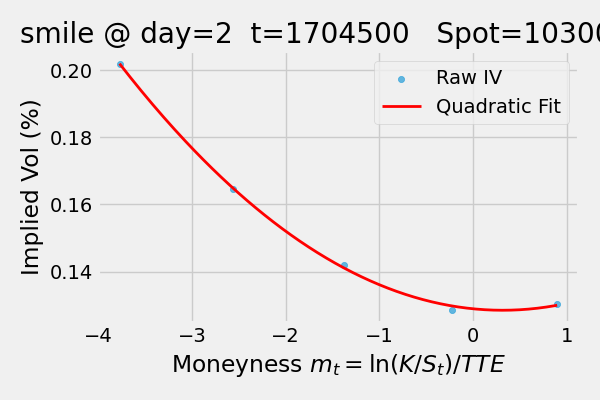

In [27]:
def plot_smile_at_price_day(
    target_price: float,
    target_day: int,
    df_iv: pd.DataFrame,
    coeffs: pd.DataFrame,
    day_window: int = 1
):
    """
    Find the timestamp closest in Volcanic Rock Price to 'target_price' withing days [target_day - day_window & target_day + day_window],
    then plot the raw IV vs. moneyness plus the quadratic fit.

    Parameters
    ---------------
    target_price : float
        The volcanic rock spot price you care about.
    taget_day : int
        The day index (e.g. 0...4) around which to search.
    df_iv : DataFrame
        Your full iv_df with columns:
            ['timestamp','day','spot_price','moneyness',IV'...]
    coeffs : DataFrame
        Your fitted coefficients from:
            coeffs = fv_iv.groupby('timestamp').appy(fit_quadratic)
        with column ['a', 'b', 'c'] and index=timestamp.
    day_window : int
        How many days on either side to include in the search.

    Displays
    ----------------
    A matplotlib figure showing the raw IV points at the chosen timestamp and the fitted smile parabola. 
    """

    days = list(range(target_day-day_window, target_day+day_window+1))
    df_days = df_iv[df_iv.day.isin(days)]

    spot_by_ts = df_days.groupby('timestamp').spot_price.first()
    ts_closest = (spot_by_ts - target_price).abs().idxmin()

    slice0 = df_iv[df_iv.timestamp == ts_closest]
    a, b, c = coeffs.loc[ts_closest, ['a', 'b', 'c']]

    m_min, m_max = slice0.moneyness.min(), slice0.moneyness.max()
    mg = np.linspace(m_min, m_max, 200)
    vg = a*mg**2 + b*mg + c

    plt.figure(figsize=(6,4))
    plt.scatter(
    slice0.moneyness,
    slice0.IV,
    s=20,
    alpha=0.6,
    label='Raw IV'
    )

    plt.plot(
    mg, vg,
    'r-',
    lw=2,
    label='Quadratic Fit'
    )
    plt.xlabel('Moneyness $m_t = \\ln(K/S_t)/TTE$')
    plt.ylabel('Implied Vol (%)')
    plt.title(
    f"smile @ day={target_day}  "
    f"t={ts_closest}   "
    f"Spot={spot_by_ts.loc[ts_closest]:.2f}"
    )
    plt.legend()
    plt.tight_layout()
    plt.show()


#-----------------------
plot_smile_at_price_day(
    target_price = 10300,
    target_day = 2,
    df_iv = df_filt,
    coeffs = coeffs,
    day_window = 1
)

In [28]:
def plot_smile_and_prices(
    target_price: float,
    target_day: int,
    time_window: int,
    df_iv: pd.DataFrame,
    coeffs: pd.DataFrame,
    day_window: int = 1
):
    """
    1) Locates the timestamp closest to 'target_price' on days in 
    [target_day - day_window & target_day + day_window]
    2) Plots the IV smile (raw poits + quadratic fit) at that timestamp.
    3) On a second subplot, plots the time-series of voucher prices for each strike 
    over [ts0-time_window & ts0+time_window].

    Parameters
    ---------------------
    target_price: float
        Desired underlying spot price to match.
    target_day: int
        between days (0...4)
    time_window: int
        Number of timestamp-units before/after ts0 to include in price plots
    df_iv: DataFrame
        Must contain ['timestamp', 'day', 'spot_price', 'strike, 'IV', 'call_price', 'moneyness'].
    coeffs: Data Frame
        Results of 'df_iv.groupby('timestamp').apply(fit_quadratic)
        with index=timestamp and columns ['a', 'b', 'c']
    day_window: int
        How many days on either side of 'target_day' to search in.
        """

    days = list(range(target_day-day_window, target_day+day_window+1))
    df_days = df_iv[df_iv.day.isin(days)]

    spot_by_ts = df_days.groupby('timestamp').spot_price.first()
    ts0 = (spot_by_ts - target_price).abs().idxmin()
    spot0 = spot_by_ts.loc[ts0]
    a,b,c = coeffs.loc[ts0, ['a', 'b', 'c']]
    slice0 = df_iv[df_iv.timestamp == ts0]

    m_min, m_max = slice0.moneyness.min(), slice0.moneyness.max()
    mg = np.linspace(m_min, m_max, 200)
    vg = a*mg**2 + b*mg + c

    t_start = ts0 - time_window
    t_end = ts0 + time_window
    df_window = df_iv[
    (df_iv.timestamp >= t_start) &
    (df_iv.timestamp <= t_end)
        ].copy()

    fig, ax_smile = plt.subplots(figsize=(8,6)
    )

    ax_smile.scatter(
        slice0.moneyness, slice0.IV,
        s=30, alpha = 0.6, label='Raw IV'
    )
    ax_smile.plot(
        mg, vg, 'r-', lw=2, label='Quadratic Fit'
    )
    ax_smile.set_xlabel('Moneyness $m_t$')
    ax_smile.set_ylabel('Implied Vol (%)')
    ax_smile.set_title(
        f"Smile @ target day={target_day},   "
        f"actual day={ts0//1_000_000}, timestamp={ts0 - 1_000_000*(ts0//1_000_000)}, spot={spot0:.2f} ")
    ax_smile.legend()
    plt.show()

    strikes = sorted(df_window['strike'].unique())
    norm = plt.Normalize(df_window.timestamp.min(), df_window.timestamp.max())
    cmap = cm.get_cmap('viridis')

    for K in strikes:
        df_k = df_window[df_window['strike'] == K].sort_values('timestamp')

        fig, (ax_ts, ax_sc) = plt.subplots(1, 2, figsize=(12,4))
        ax_ts.plot(
            df_k['timestamp'],
            df_k['call_price'],
            marker='.',
            linestyle='-',
            alpha=0.7
        )
        ax_ts.axvline(ts0, color='k', ls='--', alpha=0.5)
        ax_ts.set_title(f"Strike {K}: Price over time")
        ax_ts.set_xlabel("Timestamp")
        ax_ts.set_ylabel("Call Price")

        sc = ax_sc.scatter(
            df_k['IV'],
            df_k['call_price'],
            c=df_k['timestamp'],
            cmap=cmap,
            norm=norm,
            s=25,
            alpha=0.8
        )
        ax_sc.axvline(coeffs.loc[ts0, 'c'], color='r', ls='--',
                      alpha = 0.5, label="ATM vol @ event")
        ax_sc.set_title(f"Strike {K}: Price vs IV")
        ax_sc.set_xlabel("Implied Vol (%)")
        ax_sc.set_ylabel("Call Price")

        cbar = fig.colorbar(sc, ax=(ax_ts, ax_sc), label="Timestamp")
        plt.suptitle(f"Window $\\pm${time_window} around day={ts0//1_000_000}, timestamp={ts0 - 1_000_000*(ts0//1_000_000)}", y=1.02)
        plt.tight_layout()
        plt.show()


    

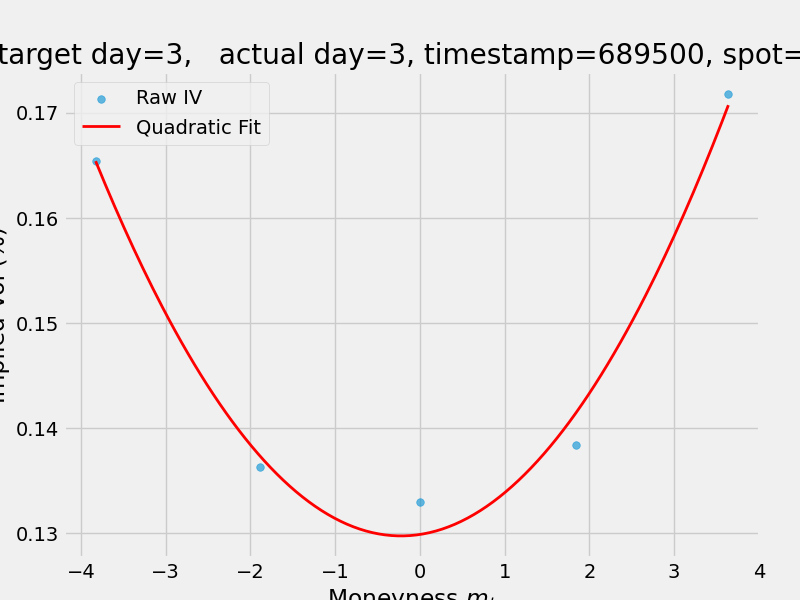

/var/folders/0l/fp7l7x9n61x0hm8_y02kj7nw0000gn/T/ipykernel_9224/2241405620.py:73: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/0l/fp7l7x9n61x0hm8_y02kj7nw0000gn/T/ipykernel_9224/2241405620.py:108: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



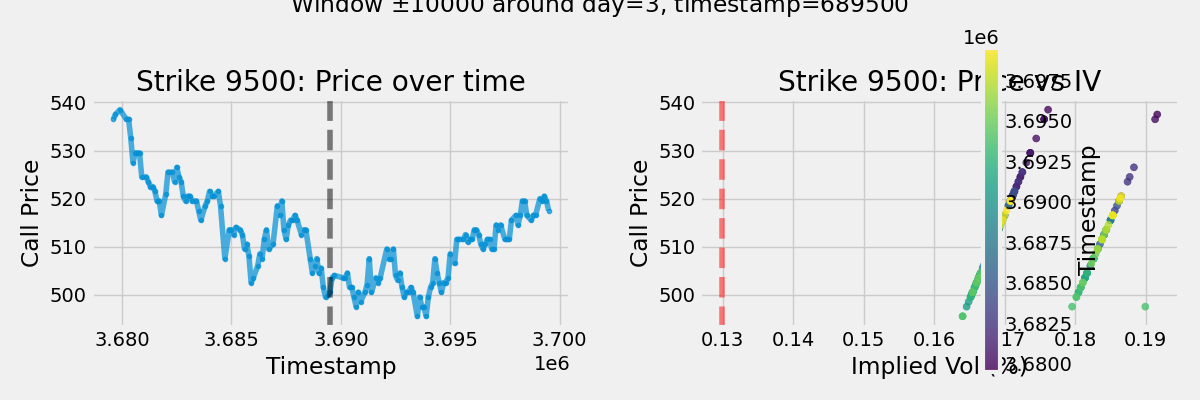

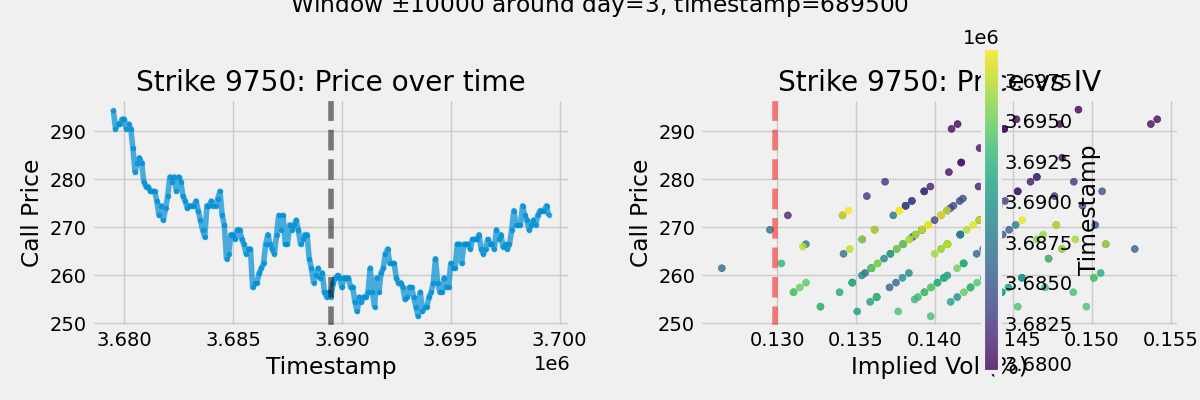

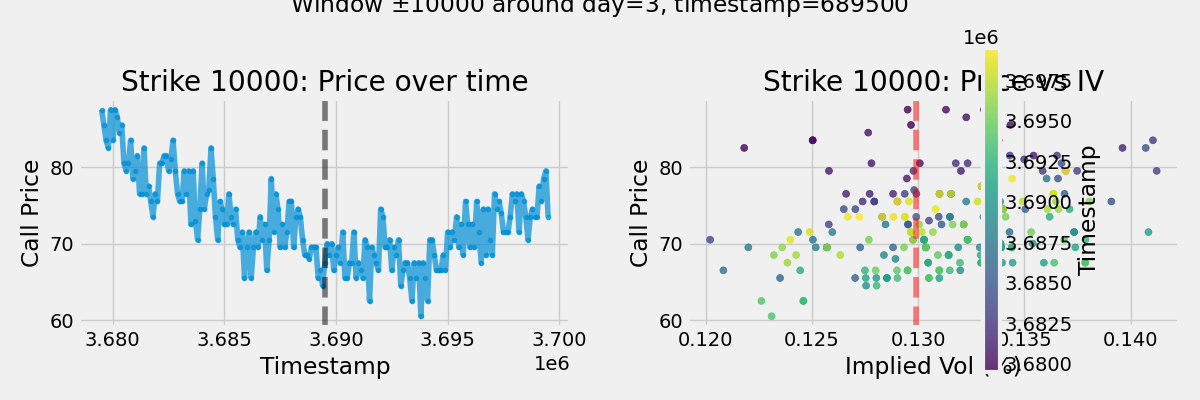

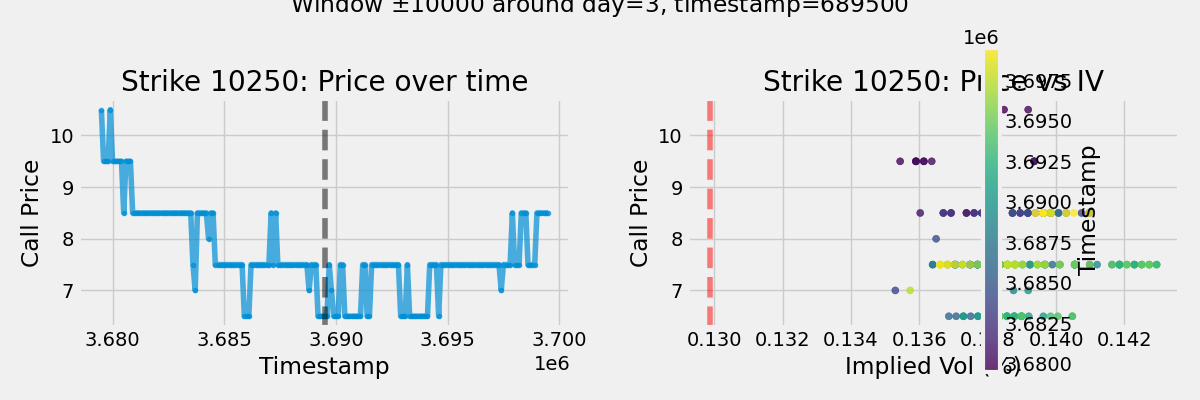

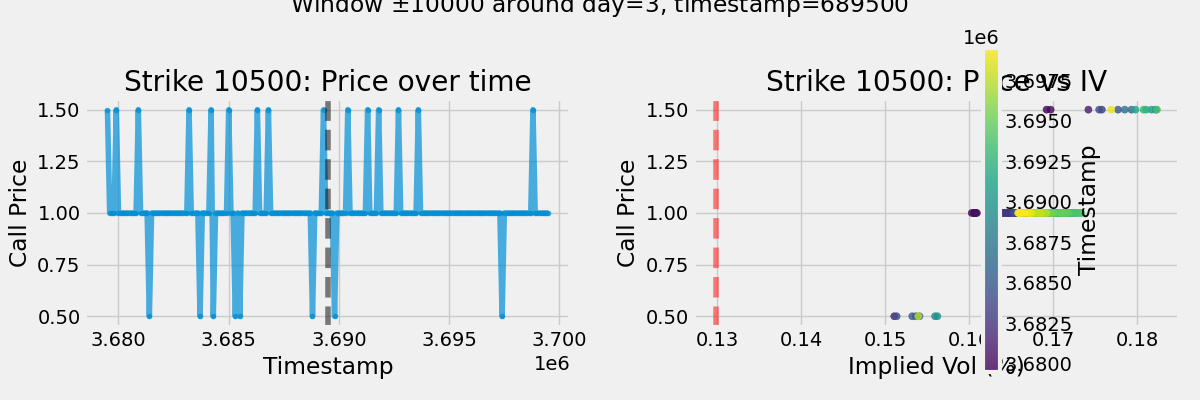

In [29]:
plot_smile_and_prices(
    target_price = 10000,
    target_day = 3,
    time_window = 10_000,
    df_iv = df_filt,
    coeffs = coeffs,
    day_window = 4
)

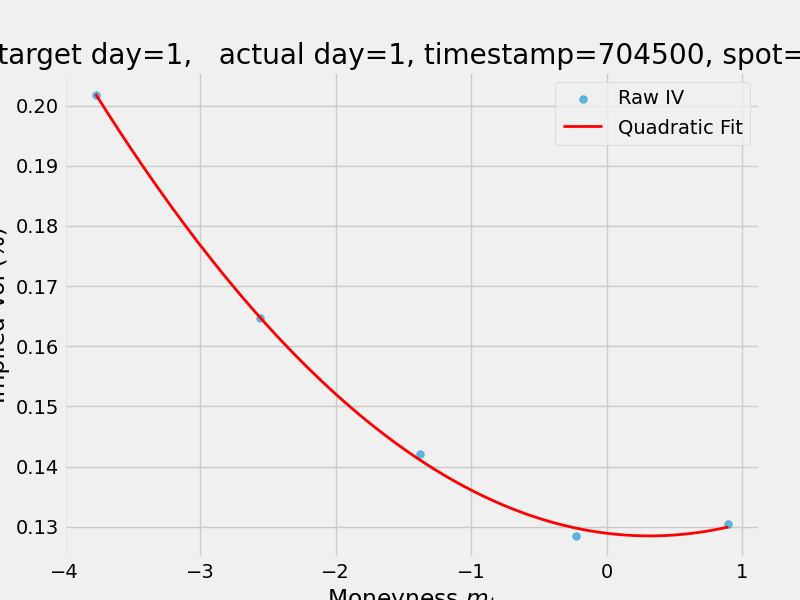

/var/folders/0l/fp7l7x9n61x0hm8_y02kj7nw0000gn/T/ipykernel_1207/2241405620.py:73: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/0l/fp7l7x9n61x0hm8_y02kj7nw0000gn/T/ipykernel_1207/2241405620.py:108: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



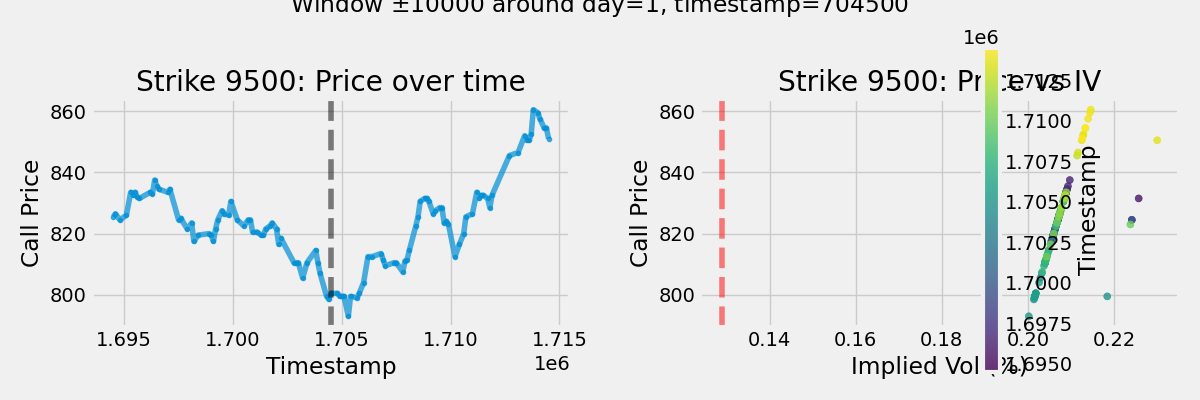

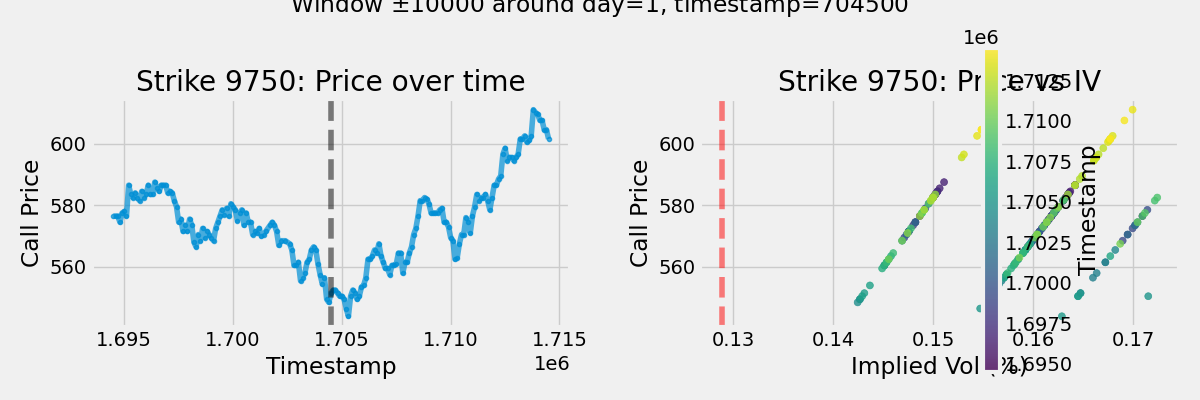

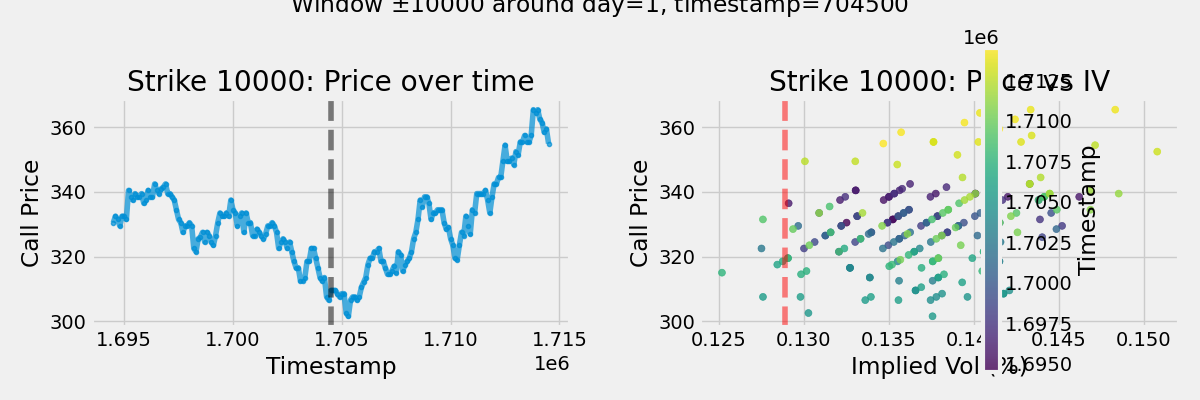

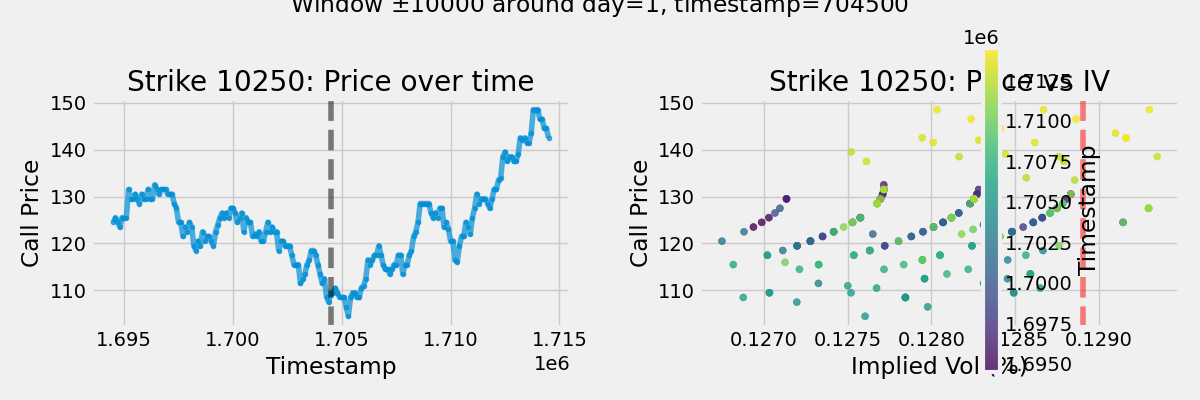

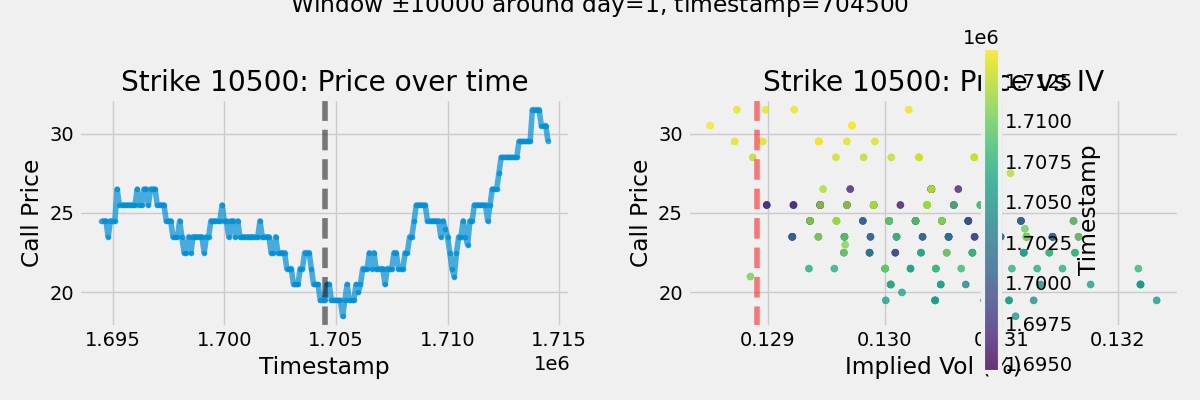

In [19]:
plot_smile_and_prices(
    target_price = 10300,
    target_day = 1,
    time_window = 10_000,
    df_iv = df_filt,
    coeffs = coeffs,
    day_window = 1
)